# mnist: fasti

redoing mnist with fastai DataBlocks

In [1]:
from fastai.vision.all import *

from files import batch_accuracy

matplotlib.rc('image', cmap='Greys')

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
mnist = DataBlock(blocks = (ImageBlock(cls=PILImageBW),CategoryBlock),
                  get_items = get_image_files,
                  splitter = RandomSplitter(seed=42),
                  get_y = parent_label)

In [4]:
dls = mnist.dataloaders(path/'training')

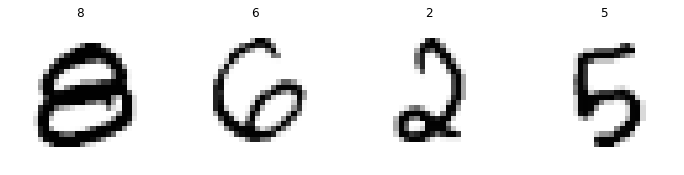

In [5]:
dls.show_batch(max_n = 4, nrows=1)

That was easy....

Train using the default learning rate...

In [6]:
learn = cnn_learner(dls, resnet34, metrics=batch_accuracy)
learn.fine_tune(2)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.712614,0.493705,0.845917,00:17


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.126643,0.069012,0.980083,00:21
1,0.054211,0.036711,0.987750,00:21


Now use learning rate finder to pick a good learning rate and see how that improves our results

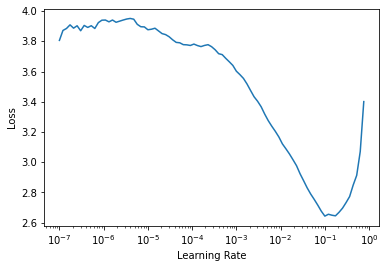

In [7]:
learn  = cnn_learner(dls, resnet34, metrics=batch_accuracy)
lr_min,lr_steep = learn.lr_find()

In [8]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 2.29e-02


In [16]:
learn = cnn_learner(dls, resnet34, metrics=batch_accuracy)
learn.fine_tune(2, base_lr=2e-2)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.266077,0.170809,0.952417,00:17


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.091674,0.059699,0.983500,00:21
1,0.030088,0.023226,0.993750,00:21


Using learning rate finder greatly improved! From 98.8 to 99.2 % accuracy!

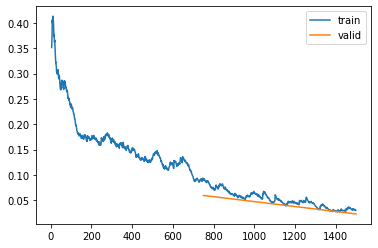

In [17]:
learn.recorder.plot_loss()

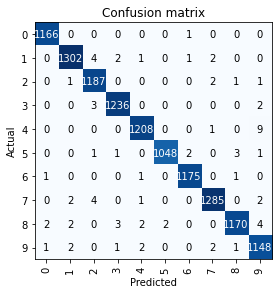

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

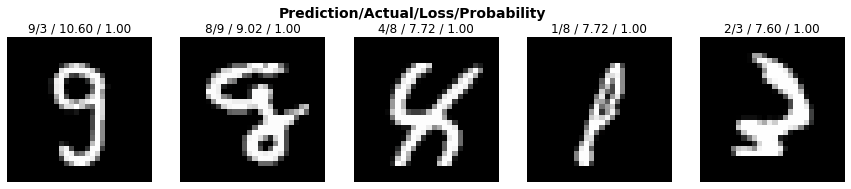

In [19]:
interp.plot_top_losses(5, nrows=1)

Using Resnet 34, we greatly improved our MNIST from scratch results! and using fewer lines by taking advantage of the fastai library

In [20]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
)
Source:   
@patch
@log_args(but_as=Learner.fit)
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR"
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      ~/Dev/Python/fastaicoursev4/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py
Type:      method


Fine tune combines multi-stage learning with unfreezing and discriminative learning rates!

## Mixed precision training with floating point 16 parameters

In [21]:
from fastai.callback.fp16 import *

In [22]:
learn = cnn_learner(dls, resnet34, metrics=batch_accuracy).to_fp16()
learn.fine_tune(2, base_lr=2e-2)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.278565,0.165241,0.951417,00:24


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.091457,0.051423,0.985333,00:31
1,0.035786,0.023993,0.992833,00:31
